In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("vietnam_housing_dataset.csv")

# 1. Drop missing critical
df = df.dropna(subset=['Price','Area'])

# 2. Convert numeric
num_cols = ['Floors','Bedrooms','Bathrooms','Area','Frontage','Access Road']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Impute missing (median tốt cho regression)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 4. Feature Engineering (quan trọng nhất)
df['Price'] = df['Price'] * 1000
df['Price_per_m2'] = df['Price'] / df['Area']
df['Area_per_room'] = df['Area'] / (df['Bedrooms'] + 1)
df['Frontage_ratio'] = df['Frontage'] / df['Area']

# 5. Clean Address
df['Address'] = df['Address'].str.split(', ').str[-2:].str.join(', ')

# 6. Handle rare locations
top_locations = df['Address'].value_counts().nlargest(20).index
df['Address'] = np.where(df['Address'].isin(top_locations), df['Address'], 'Other')

# 7. Remove outliers (IQR)
Q1 = df['Price_per_m2'].quantile(0.25)
Q3 = df['Price_per_m2'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Price_per_m2'] >= Q1 - 1.5*IQR) & (df['Price_per_m2'] <= Q3 + 1.5*IQR)]

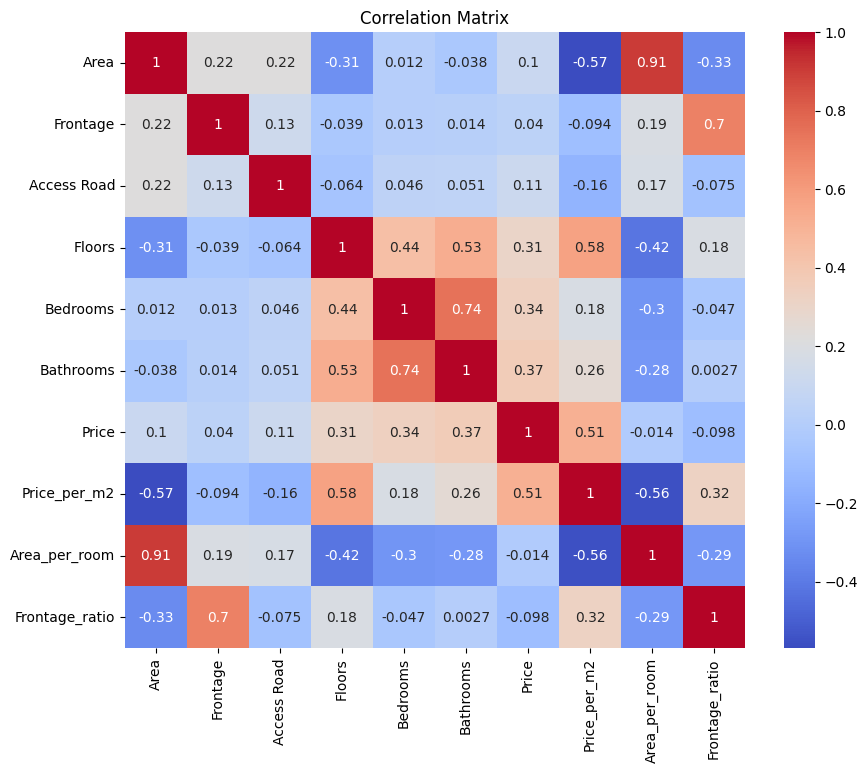

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

X = df[['Area','Bedrooms','Bathrooms','Floors','Frontage','Access Road',
        'Area_per_room','Frontage_ratio','Address']]
y = df['Price']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [6]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

                            Feature  Coefficient
4                          Frontage   626.108661
3                            Floors   508.451931
2                         Bathrooms   321.759048
0                              Area   255.835742
5                       Access Road   201.199428
1                          Bedrooms   147.488129
25    Address_Tân Bình, Hồ Chí Minh     5.144663
11         Address_Cầu Giấy, Hà Nội     4.384219
9   Address_Bình Thạnh, Hồ Chí Minh    -6.039090
26     Address_Tân Phú, Hồ Chí Minh   -24.510479
23       Address_Thanh Xuân, Hà Nội   -61.794333
27          Address_Đống Đa, Hà Nội   -69.409484
21      Address_Quận 7, Hồ Chí Minh   -73.075765
6                     Area_per_room   -95.029256
22      Address_Quận 9, Hồ Chí Minh   -95.856654
13      Address_Gò Vấp, Hồ Chí Minh  -103.550903
14     Address_Hai Bà Trưng, Hà Nội  -113.641492
24     Address_Thủ Đức, Hồ Chí Minh  -154.506052
17        Address_Long Biên, Hà Nội  -175.030237
15        Address_Ho

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print(f"R2 Score: {r2:.2f}")

MAE: 1464.292395682228
RMSE: 1828.455652173904
R2 Score: 0.30


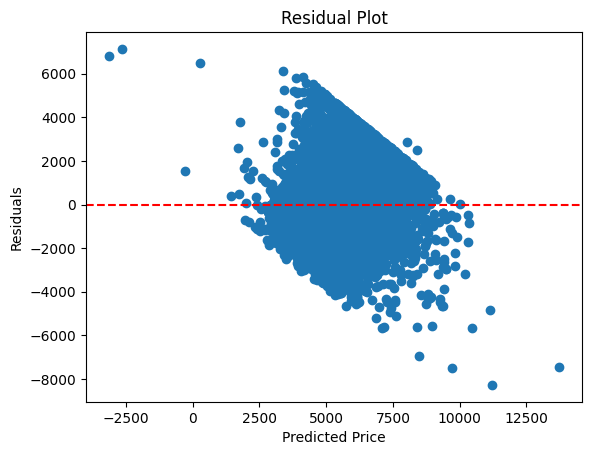

In [ ]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i)
                   for i in range(X_train_scaled.shape[1])]
print(vif_data)

                            feature        VIF
0                              Area  12.479832
1                          Bedrooms   3.247245
2                         Bathrooms   2.618728
3                            Floors   2.046198
4                          Frontage   3.825020
5                       Access Road   1.103385
6                     Area_per_room  12.053196
7                    Frontage_ratio   4.165330
8        Address_Biên Hòa, Đồng Nai   2.215118
9   Address_Bình Thạnh, Hồ Chí Minh   2.673607
10    Address_Bình Tân, Hồ Chí Minh   3.250185
11         Address_Cầu Giấy, Hà Nội   2.056723
12        Address_Dĩ An, Bình Dương   2.201904
13      Address_Gò Vấp, Hồ Chí Minh   3.620412
14     Address_Hai Bà Trưng, Hà Nội   2.386248
15        Address_Hoàng Mai, Hà Nội   2.884037
16          Address_Hà Đông, Hà Nội   3.338006
17        Address_Long Biên, Hà Nội   3.247023
18     Address_Nha Trang, Khánh Hòa   2.362641
19                    Address_Other  15.604604
20     Addres

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [ ]:
coefficients = model.coef_
intercept = model.intercept_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 5853.122712146423
Coefficients: [ 255.83574151  147.48812918  321.75904834  508.45193143  626.1086606
  201.19942783  -95.02925612 -767.02724711 -388.18378103   -6.03909024
 -271.15513445    4.38421909 -363.83388103 -103.55090289 -113.64149199
 -201.02949903 -214.81855249 -175.03023748 -277.75416996 -884.66249935
 -306.31767796  -73.07576475  -95.85665422  -61.79433283 -154.50605194
    5.14466308  -24.51047865  -69.4094839 ]


In [ ]:
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
})

coef_df = coef_df.sort_values(by="Coefficient", ascending=False)
print(coef_df)

                            Feature  Coefficient
4                          Frontage   626.108661
3                            Floors   508.451931
2                         Bathrooms   321.759048
0                              Area   255.835742
5                       Access Road   201.199428
1                          Bedrooms   147.488129
25    Address_Tân Bình, Hồ Chí Minh     5.144663
11         Address_Cầu Giấy, Hà Nội     4.384219
9   Address_Bình Thạnh, Hồ Chí Minh    -6.039090
26     Address_Tân Phú, Hồ Chí Minh   -24.510479
23       Address_Thanh Xuân, Hà Nội   -61.794333
27          Address_Đống Đa, Hà Nội   -69.409484
21      Address_Quận 7, Hồ Chí Minh   -73.075765
6                     Area_per_room   -95.029256
22      Address_Quận 9, Hồ Chí Minh   -95.856654
13      Address_Gò Vấp, Hồ Chí Minh  -103.550903
14     Address_Hai Bà Trưng, Hà Nội  -113.641492
24     Address_Thủ Đức, Hồ Chí Minh  -154.506052
17        Address_Long Biên, Hà Nội  -175.030237
15        Address_Ho